# TESTER
# NCAR JupyterHub Large Data Example Notebook

*Note: If you do not have access to the NCAR machine, please look at the AWS-LENS example notebook instead.*

This notebook demonstrates how to compare large datasets on glade with ldcpy.  In particular, we will look at data from CESM-LENS1 project (http://www.cesm.ucar.edu/projects/community-projects/LENS/data-sets.html). In doing so, we will start a DASK client from Jupyter.  This notebook is meant to be run on NCAR's JupyterHub (https://jupyterhub.ucar.edu). We will use a subset of the CESM-LENS1 data on glade is located in /glade/p/cisl/asap/ldcpy_sample_data. 

We assume that you have a copy of the ldcpy code on NCAR's glade filesystem, obtained via:<br>
    `git clone https://github.com/NCAR/ldcpy.git`

When you launch your NCAR JupyterHub session, you will need to indicate a machine (Casper) and then you will need your charge account.  You can then launch the session and navigate to this notebook.  

Here's good resource for using NCAR's JupyterHub:<br>
https://ncar-hackathons.github.io/jupyterlab-tutorial/jhub.html)


**You need to run your notebook with the "cmip6-201910" kernel (choose from the dropdown in the upper left.)**


Note that the compressed data that we are using was generated for this paper:

Allison H. Baker, Dorit M. Hammerling, Sheri A. Mickelson, Haiying Xu, Martin B. Stolpe, Phillipe Naveau, Ben Sanderson, Imme Ebert-Uphoff, Savini Samarasinghe, Francesco De Simone, Francesco Carbone, Christian N. Gencarelli, John M. Dennis, Jennifer E. Kay, and Peter Lindstrom, “Evaluating Lossy Data Compression on Climate Simulation Data within a Large Ensemble.”  Geoscientific Model Development, 9, pp. 4381-4403, 2016 
(https://gmd.copernicus.org/articles/9/4381/2016/)




## Setup
Let's set up our environment.  First, make sure that you are using the cmip6-2019.10 kernel on Casper.  Then you will need to modify the path below to indicate where you have cloned ldcpy. (_Note: soon we will install ldcpy on Casper in the cmpi6-2019.10 kernel_ .)

If you want to use the dask dashboard, then the dask.config link must be set below (modify for your path in your browser).  

In [1]:
#Make sure you are using the cmpi6-2019.10 kernel 

#Add ldcpy root to system path (MODIFY FOR YOUR LDCPY CODE LOCATION)
import sys
sys.path.insert(0,'/glade/u/home/abaker/repos/ldcpy')
import ldcpy

#Display output of plots directly in Notebook
%matplotlib inline
#Automatically reload module if it is editted
%reload_ext autoreload
%autoreload 2

#silence warnings
import warnings
warnings.filterwarnings("ignore")

#if you want to use the DASK daskboard, then modify the below and run
import dask
dask.config.set({'distributed.dashboard.link' : 'https://jupyterhub.ucar.edu/dav/user/abaker/proxy/{port}/status'})


### Connect to DASK distributed cluster (Casper uses slurm):

In [2]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(memory="40GB", cores=4, processes=1, walltime="00:45:00", project="NIOW0001")
#scale as needed
cluster.adapt(minimum_jobs=1, maximum_jobs=35)
cluster

In [ ]:
# Look at the job script (optional)
print(cluster.job_script())

In [3]:
# Connect client to the remote dask workers
client = Client(cluster)
client

Client Scheduler: tcp://10.12.205.11:41346 Dashboard: https://jupyterhub.ucar.edu/dav/user/abaker/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## The sample data on the glade filesystem

In /glade/p/cisl/asap/ldcpy_sample_data on glade, we have TS (surface temperature), PRECT (precipiation rate), and PS (surface pressure) data from CESM-LENS1. These all all 2D variables.  TS and PRECT have daily output, and PS has monthly output.  We have the compressed and original versions of all these variables that we would like to compare with ldcpy.

First we list what is in this directory (two subdirectories):

In [ ]:
#list directory contents
import os
os.listdir('/glade/p/cisl/asap/ldcpy_sample_data')

Now we look at the contents of each subdirectory.  We have 6 files in each, consisting of 2 different timeseries files for each variable (1920-2005 and 2006-2080).

In [ ]:
#list lossy directory contents (files that have been lossy compressed and reconstructed)
lossy_files = os.listdir('/glade/p/cisl/asap/ldcpy_sample_data/lossy')
lossy_files

In [ ]:
#list orig (i.e., uncompressed) directory contents
orig_files = os.listdir('/glade/p/cisl/asap/ldcpy_sample_data/orig')
orig_files

We can look at how big these files are...

In [ ]:
print ('Original files')
for f in orig_files:
    print(f ," ", os.stat('/glade/p/cisl/asap/ldcpy_sample_data/orig/' + f).st_size/1e9, 'GB')

### Open datasets

First, let's look at the original and reconstructed files for the monthly surface Pressure (PS) data for 1920-2006. We begin by using ldcpy.open_dataset() to open the files of interest into our dataset collection.  Note that for this dataset, we use "persist.()" after open_datasets() to speed up subsequent calculations.

In [4]:
#load the first 86 years of montly surface pressure into a collection

col_PS = ldcpy.open_datasets(["PS"], ['/glade/p/cisl/asap/ldcpy_sample_data/orig/PS.monthly.192001-200512.nc', 
                            '/glade/p/cisl/asap/ldcpy_sample_data/lossy/c.PS.monthly.192001-200512.nc'],
                           ['orig', 'lossy']).persist()
col_PS


dataset size in GB 0.46



<xarray.Dataset>
Dimensions:     (collection: 2, lat: 192, lon: 288, time: 1032)
Coordinates:
  * lat         (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * time        (time) object 1920-02-01 00:00:00 ... 2006-01-01 00:00:00
  * lon         (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * collection  (collection) <U5 'orig' 'lossy'
Data variables:
    PS          (collection, time, lat, lon) float32 dask.array<chunksize=(1, 1032, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e11.B20TRC5CNBDRD.f09_g16.031
    title:            UNSET
    logname:          mickelso
    host:             ys0219
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     b.e11.B20TRC5CNBDRD.f09_g16.001.cam.i.1920-01-01-00000.nc
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/USGS-gtop...

## Data comparison

Now we use the ldcpy package features to compare the data.

### Surface Pressure 
Let's look at the comparison statistics at the first timeslice for PS.

In [5]:
ldcpy.compare_stats(col_PS, 'PS', 'orig', 'lossy', time=0)

Comparing orig data (set1) to lossy data (set2)
 
mean set1: 96750
mean set2: 96730
mean diff: 15.81
 
variance set1: 8.425e+07
variance set2: 8.425e+07
 
standard deviation set1: 9179
standard deviation set2: 9179
 
max value set1: 103000
max value set2: 103000
min value set1: 51970
min value set2: 51950
 
max abs diff: 31.99
min abs diff: 0
mean abs diff: 15.81
mean squared diff: 249.8
root mean squared diff: 18.3
normalized root mean squared diff: 0.0003587
normalized max pointwise error: 0.000627
pearson correlation coefficient: 1
ks p-value: 0.01454
spatial relative error(% > 0.0001): 69.08
ssim: 0.9978


In [6]:
from ldcpy.metrics import DatasetMetrics, DiffMetrics
ds0_metrics = DatasetMetrics(col_PS["PS"].sel(collection="orig").isel(time=0), ['lat', 'lon'])

In [8]:
ds0_metrics.get_metric('mean').data.compute()


96750.2045633528

In [9]:
col_TS = ldcpy.open_datasets(["TS"],
                            ['/glade/p/cisl/asap/ldcpy_sample_data/orig/TS.daily.19200101-20051231.nc', 
                                 '/glade/p/cisl/asap/ldcpy_sample_data/lossy/c.TS.daily.19200101-20051231.nc'],
                         ['orig', 'lossy'], chunks={'time': 100}).persist()
col_TS

dataset size in GB 13.89



,Array,Chunk
Bytes,13.89 GB,22.12 MB
Shape,"(2, 31390, 192, 288)","(1, 100, 192, 288)"
Count,628 Tasks,628 Chunks
Type,float32,numpy.ndarray


In [10]:
from ldcpy.metrics import DatasetMetrics, DiffMetrics
ds1_metrics = DatasetMetrics(col_TS["TS"].sel(collection="orig").isel(time=0), ['lat', 'lon'])

In [11]:
pp = ds1_metrics.get_metric('mean').data
pp

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [12]:
pp.compute()

274.7145136412647

In [14]:
ll = ds1_metrics.get_metric('mean').data

In [15]:
ll.compute()

274.7145136412647

In [ ]:
import numpy as np
pp.dtype
tt = pp

In [ ]:
output = {}
output['hi'] =  pp
output

In [ ]:
tt

In [ ]:
ll

In [ ]:
print(output['hi'])

Now we compare the mean PS values across time in the orig and lossy datasets.

In [ ]:
# comparison between mean PS values in ds_PS orig and lossy datasets
ldcpy.plot(col_PS, "PS", sets=['orig', 'lossy'], metric='mean', calc_ssim = True)

Now we instead show the difference plot for the above plots.

In [ ]:
# diff between mean PS values in ds_PS orig and lossy datasets
ldcpy.plot(col_PS, "PS", sets=['orig','lossy'], metric='mean', metric_type='diff')

We can also look at mean differences over time.  Here we are looking at the spatial averages and then grouping by day of the year.

In [ ]:
# Time-series plot of mean PS differences between ds_PS orig and ds_PS lossy datasets grouped by month of year
ldcpy.plot(col_PS, "PS", sets=['orig',"lossy"], metric='mean', plot_type="time_series", 
           group_by="time.month", metric_type="diff")

In [ ]:
# Time-series plot of PS mean (grouped by month) in the original and lossy datasets
ldcpy.plot(col_PS, "PS", sets=['orig', 'lossy'], metric='mean', plot_type="time_series", group_by="time.month")

### Surface Temperature

Now let's open the daily surface temperature (TS) data for 1920-2006 into a collection. These are larger files than the monthly PS data.

In [16]:
#load the first 86 years of daily surface temperature (TS) data
col_TS = ldcpy.open_datasets(["TS"],
                            ['/glade/p/cisl/asap/ldcpy_sample_data/orig/TS.daily.19200101-20051231.nc', 
                                 '/glade/p/cisl/asap/ldcpy_sample_data/lossy/c.TS.daily.19200101-20051231.nc'],
                         ['orig', 'lossy'], chunks={'time': 100}).persist()
col_TS

dataset size in GB 13.89



,Array,Chunk
Bytes,13.89 GB,22.12 MB
Shape,"(2, 31390, 192, 288)","(1, 100, 192, 288)"
Count,628 Tasks,628 Chunks
Type,float32,numpy.ndarray


In [ ]:
col_PRECT = ldcpy.open_datasets(["PRECT"],
                            ['/glade/p/cisl/asap/ldcpy_sample_data/orig/PRECT.daily.20060101-20801231.nc', 
                                 '/glade/p/cisl/asap/ldcpy_sample_data/lossy/c.PRECT.daily.20060101-20801231.nc'],
                         ['orig', 'lossy'], chunks={'time': 100}).persist()
col_PRECT

Look at the first time slice (time = 0) statistics:

In [17]:
ldcpy.compare_stats(col_TS, 'TS', 'orig', 'lossy', time=31389)

Comparing orig data (set1) to lossy data (set2)
 
mean set1: 275.7
mean set2: 275.6
mean diff: 0.05494
 
variance set1: 505.7
variance set2: 505.2
 
standard deviation set1: 22.49
standard deviation set2: 22.48
 
max value set1: 311.5
max value set2: 311.5
min value set1: 221.3
min value set2: 221.2
 
max abs diff: 0.125
min abs diff: 0
mean abs diff: 0.05494
mean squared diff: 0.003019
root mean squared diff: 0.06519
normalized root mean squared diff: 0.0007225
normalized max pointwise error: 0.001385
pearson correlation coefficient: 1
ks p-value: 0.006619
spatial relative error(% > 0.0001): 73.53
ssim: 0.9981


In [ ]:
ots = col_TS.sel(collection='orig')

In [ ]:
lts = col_TS.sel(collection='lossy')

In [ ]:
lts.TS.isel(time=31390).values

Now we compare mean TS over time:

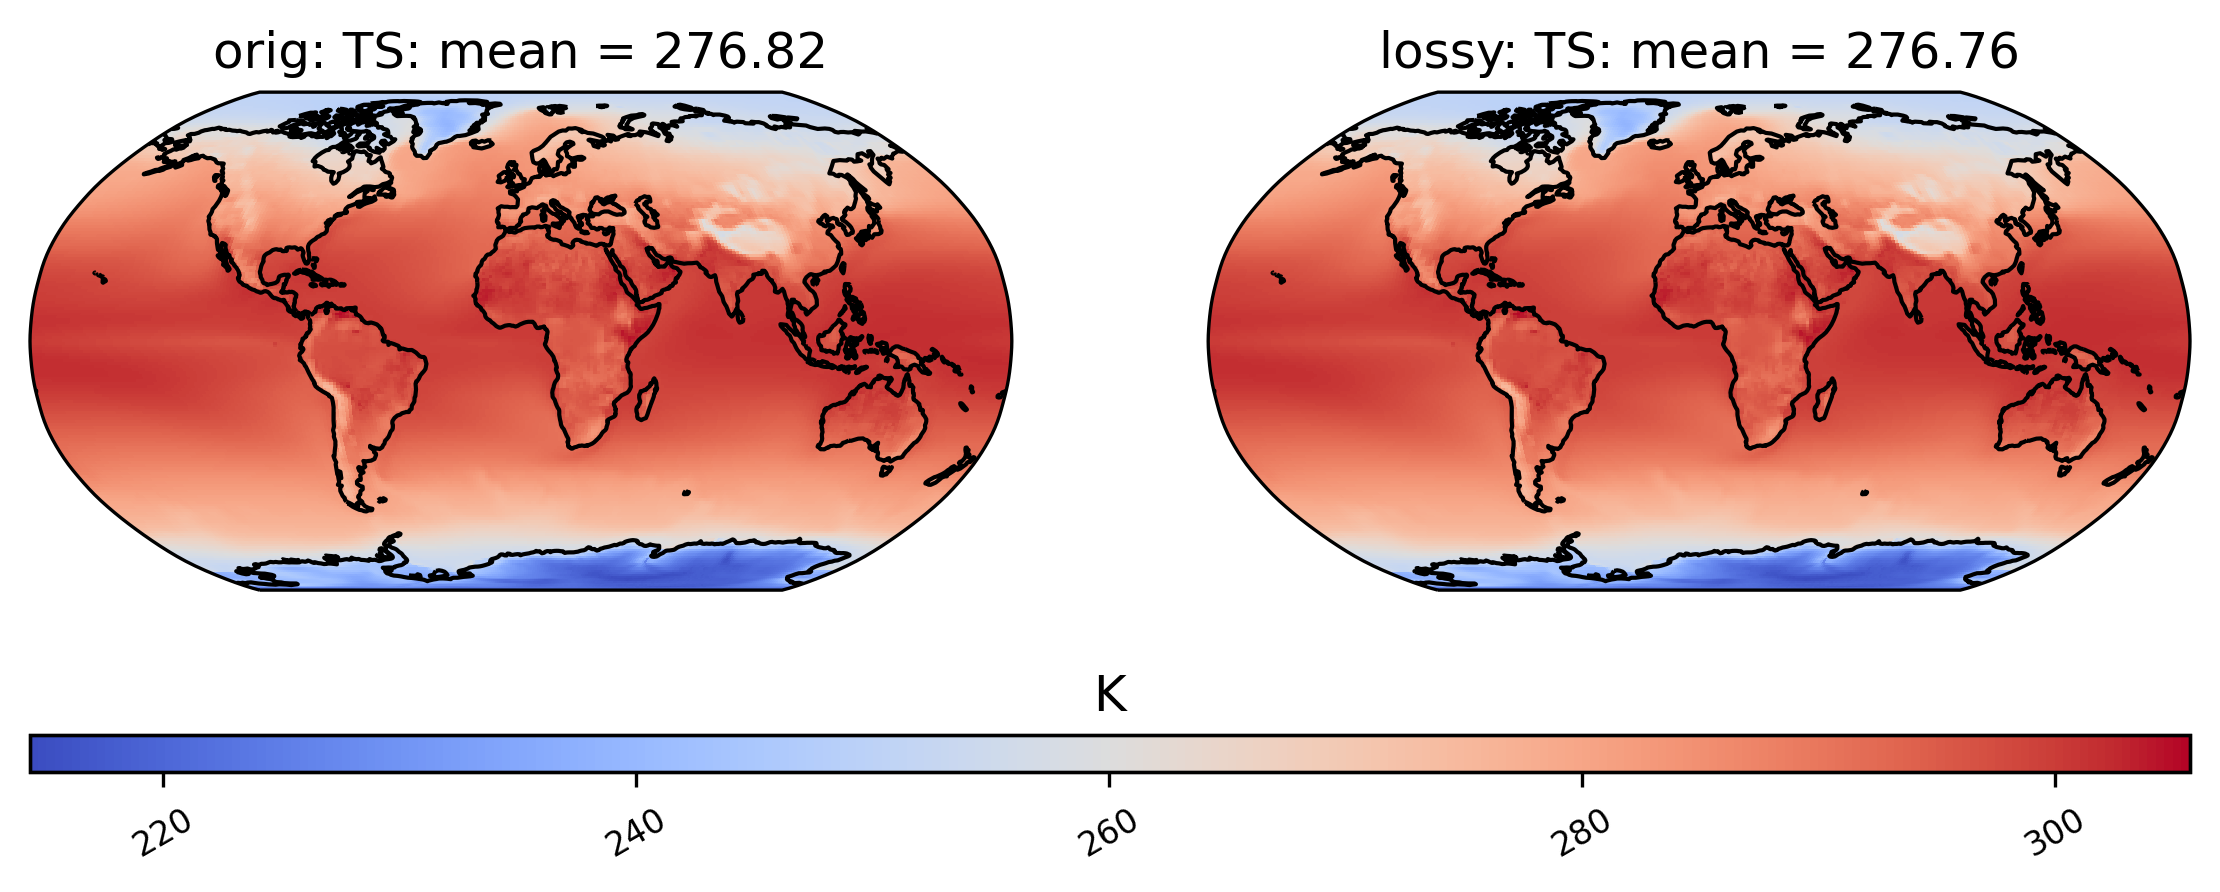

In [18]:
# comparison between mean TS values in ds_TS orig and lossy datasets
ldcpy.plot(col_TS, "TS", sets=['orig', 'lossy'], metric='mean')

In [ ]:
import xarray as xr
o_ds = xr.open_dataset("/glade/p/cisl/asap/ldcpy_sample_data/orig/TS.daily.19200101-20051231.nc")
new_ds = xr.open_dataset("/glade/p/cisl/asap/ldcpy_sample_data/orig/new.TS.daily.19200101-20051231.nc")

In [ ]:
new_ds

In [ ]:
o_ds

In [ ]:
l_ds = xr.open_dataset("/glade/p/cisl/asap/ldcpy_sample_data/lossy/c.TS.daily.19200101-20051231.nc")

In [ ]:
l_t0 = l_ds.TS.isel(time=0).values

In [ ]:
o_t0 = o_ds.TS.isel(time=0).values
o_t1 = o_ds.TS.isel(time=1).values
l_t1 = l_ds.TS.isel(time=1).values
l_tend = l_ds.TS.isel(time=31389).values
o_tend = o_ds.TS.isel(time=31389).values
o_tplus = o_ds.TS.isel(time=31390).values
n_tend = new_ds.TS.isel(time=31389).values

In [ ]:
o_ds.time[31389]

In [ ]:
l_ds.time[31389]

In [ ]:
list_of_files = ['/glade/p/cisl/asap/ldcpy_sample_data/orig/TS.daily.19200101-20051231.nc', 
                                 '/glade/p/cisl/asap/ldcpy_sample_data/lossy/c.TS.daily.19200101-20051231.nc']

In [ ]:
for i, file in enumerate(list_of_files):
    print(i)

In [ ]:
o_ds.sizes['time']

In [ ]:
sz = np.zeros(len(list_of_files))

In [ ]:
sz

In [ ]:
sz2 = sz
sz2[0] = 4
sz2

In [ ]:
indx = np.unique(sz2)    
indx.size

In [ ]:
assert indx.size == 1, 'all datasets must have the same length time dimension'


In [ ]:
new_ds.sizes['time']


In [ ]:
l_t0

In [ ]:
import numpy as np
np.linalg.norm(n_tend-l_tend)

Continue doing any comparisons that you like.  Be sure to close the cluster and client when finished.

In [ ]:
cluster.close()
client.close()